Part 2 of https://link.springer.com/content/pdf/10.1007/s11263-006-7934-5.pdf

In [214]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

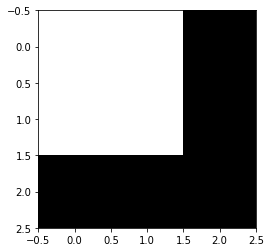

In [215]:
# Create a simple image
img = np.zeros((3,3))
img[:2,:2] = 1
plt.imshow(img, cmap='gray')
plt.show()

In [216]:
# Prior
O = [(0,0), (0,1)] # Prior Object - Source S
B = [(2,2)] # Prior Background - Sink T

# Associated histograms
nbins = 10
hist_O = np.histogram(O, bins=nbins, density=True)
hist_B = np.histogram(B, bins=nbins, density=True)
hists = dict(obj=hist_O, bkg=hist_B)

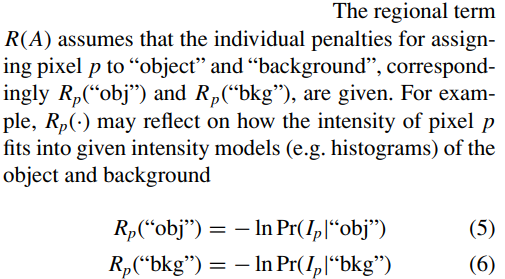

In [217]:
def get_prob(hist, value):
    """Get probability of the input value from the input histogram."""
    counts, bin_edges = hist
    bin = np.argmax(bin_edges - value > 0) - 1
    if bin == -1:
        return 0
    else:
        return counts[bin] / counts.sum()

def Rp(p, label, eps=1e-10, hists=hists):
    """The regional term for a pixel p, with eps to prevent infinity."""
    proba = get_prob(hists[label], img[p])
    return -np.log(proba or eps)

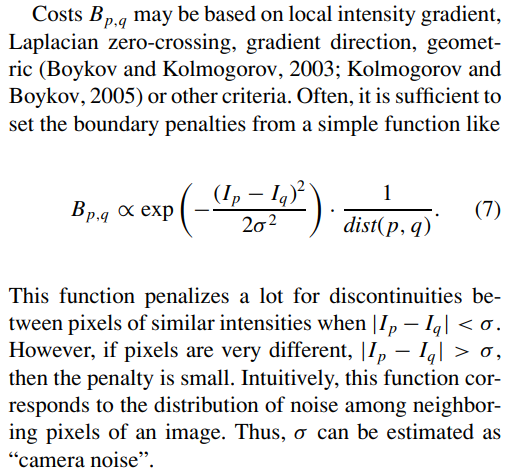

In [218]:
def dist(p, q):
    """Distance L1 between pixels p and q."""
    return abs(p[0]-q[0]) + abs(p[1]-q[1])

def Bpq(p, q, sig=1):
    """The boundary properties term between pixels p and q."""
    return np.exp(-(img[p]-img[q])**2/(2*sig**2)) / dist(p,q)

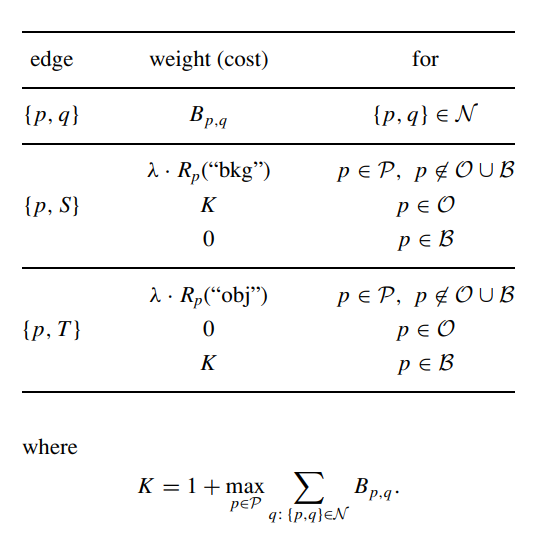

In [219]:
def get_weight(p, q, O=O, B=B, λ=1, K=None):
    """Compute weight between nodes p and q.
    When q is the source S or the sink T, K must be given.
    """
    if q == 'S':
        if p in O:
            return K
        if p in B:
            return 0
        return λ*Rp(p,"bkg")
    
    if q == 'T':
        if p in O:
            return 0
        if p in B:
            return K
        return λ*Rp(p,"obj")
    
    return Bpq(p,q)

Create graph without S & T.

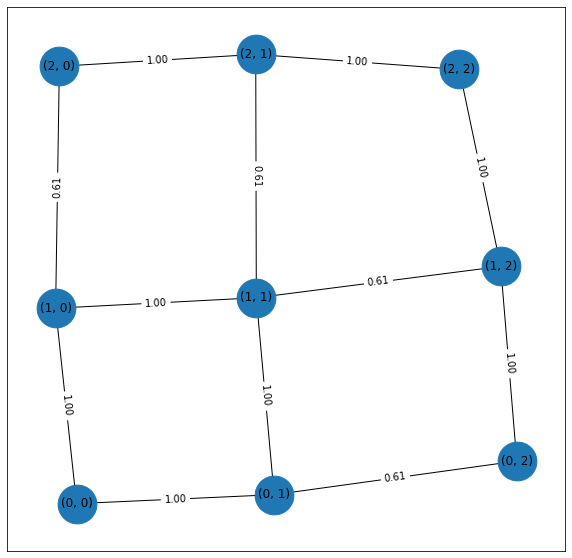

In [224]:
G = nx.Graph()
n,p = img.shape

for i in range(n):
    for j in range(p):
        if i+1 < n:
            G.add_edge((i,j),(i+1,j), weight=get_weight((i,j),(i+1,j)))
        if j+1 < p:
            G.add_edge((i,j),(i,j+1), weight=get_weight((i,j),(i,j+1)))

plt.figure(figsize=(10,10))
pos=nx.spring_layout(G) # pos = nx.nx_agraph.graphviz_layout(G)
nx.draw_networkx(G, pos, node_size=1500)
labels = {k:f'{v:.2f}'for (k,v) in nx.get_edge_attributes(G,'weight').items()}
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)
plt.show()

Add S and T, and visualize their edges separately.

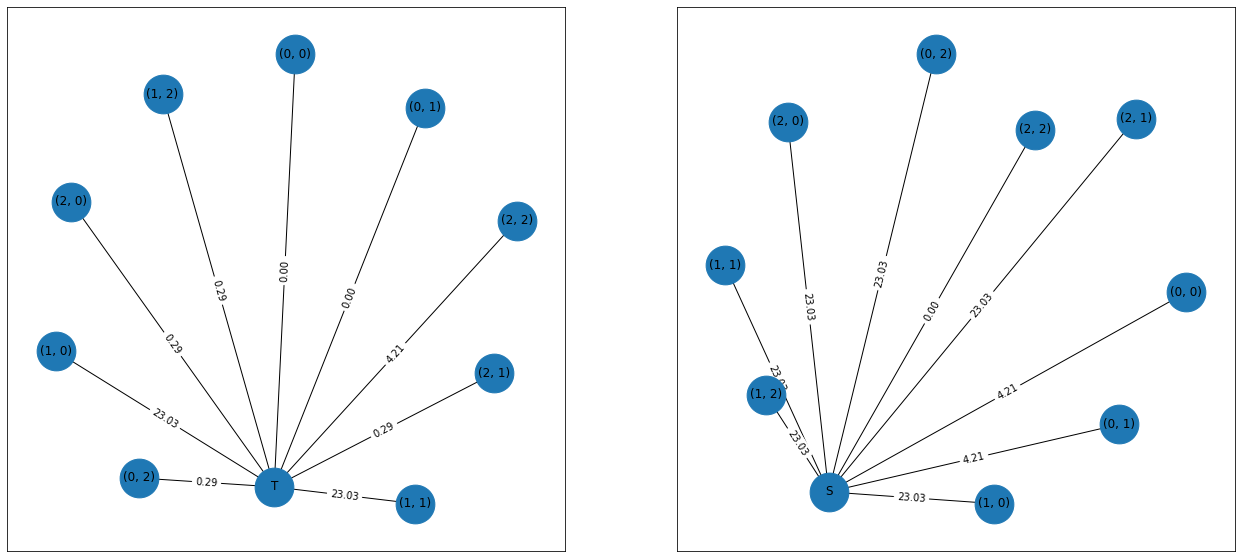

In [225]:
# Just for plot purposes
G_T = nx.Graph()
G_S = nx.Graph()

# Compute K
K = 0
for x in G.nodes:
    K = max(K, np.sum([G.get_edge_data(x,y)['weight'] for y in G.neighbors(x)]))
K += 1

# Add edges
for i in range(n):
    for j in range(p):
        G.add_edge((i,j),'S', weight=get_weight((i,j),'S',K=K))
        G.add_edge((i,j),'T', weight=get_weight((i,j),'T',K=K))
        
        # Just for plot purposes
        G_S.add_edge((i,j),'S', weight=get_weight((i,j),'S',K=K))
        G_T.add_edge((i,j),'T', weight=get_weight((i,j),'T',K=K))

# Plot
plt.figure(figsize=(22,10))
# T edges
plt.subplot(121)
pos = nx.spring_layout(G_T, k=10)
nx.draw_networkx(G_T, pos, node_size=1500)
labels = {k:f'{v:.2f}'for (k,v) in nx.get_edge_attributes(G_T,'weight').items()}
nx.draw_networkx_edge_labels(G_T,pos,edge_labels=labels)
# S edges
plt.subplot(122)
pos = nx.spring_layout(G_S, k=10)
nx.draw_networkx(G_S, pos, node_size=1500)
labels = {k:f'{v:.2f}'for (k,v) in nx.get_edge_attributes(G_S,'weight').items()}
nx.draw_networkx_edge_labels(G_S,pos,edge_labels=labels)
plt.show()

In [226]:
# Edges values
[((u,v),G.get_edge_data(u,v)['weight']) for (u,v) in G.edges]

[(((0, 0), (1, 0)), 1.0),
 (((0, 0), (0, 1)), 1.0),
 (((0, 0), 'S'), 4.213061319425266),
 (((0, 0), 'T'), 0),
 (((1, 0), (2, 0)), 0.6065306597126334),
 (((1, 0), (1, 1)), 1.0),
 (((1, 0), 'S'), 23.025850929940457),
 (((1, 0), 'T'), 23.025850929940457),
 (((0, 1), (1, 1)), 1.0),
 (((0, 1), (0, 2)), 0.6065306597126334),
 (((0, 1), 'S'), 4.213061319425266),
 (((0, 1), 'T'), 0),
 (((1, 1), (2, 1)), 0.6065306597126334),
 (((1, 1), (1, 2)), 0.6065306597126334),
 (((1, 1), 'S'), 23.025850929940457),
 (((1, 1), 'T'), 23.025850929940457),
 (((0, 2), (1, 2)), 1.0),
 (((0, 2), 'S'), 23.025850929940457),
 (((0, 2), 'T'), 0.2876820724517809),
 (((1, 2), (2, 2)), 1.0),
 (((1, 2), 'S'), 23.025850929940457),
 (((1, 2), 'T'), 0.2876820724517809),
 (((2, 0), (2, 1)), 1.0),
 (((2, 0), 'S'), 23.025850929940457),
 (((2, 0), 'T'), 0.2876820724517809),
 (((2, 1), (2, 2)), 1.0),
 (((2, 1), 'S'), 23.025850929940457),
 (((2, 1), 'T'), 0.2876820724517809),
 (((2, 2), 'S'), 0),
 (((2, 2), 'T'), 4.213061319425266)